In [1]:
%run init_notebook.py

In [4]:
from src.nlp_lists import DICT_NARRATIVES, LST_FREQUENT_NON_MEANING
from settings import MODELS_DIR

In [5]:
import pickle
import spacy

import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import RandomizedSearchCV

import time
import gc

from scipy.stats import uniform

In [6]:
from src.utils import load_pickle, save_pkl, save_pd_df
from src.nlp_utils import get_lda_n_top_words, PTWGuidedLatentDirichletAllocation

# load data

In [7]:
lst_files = [i for i in os.listdir(NEWS_TEXT_DIR) if i not in ['orig']]
# lst_files = [lst_files[i] for i in np.random.randint(0, high=len(lst_files), size=2_000)]

In [8]:
dict_txts = {}
for file in lst_files:
    dict_txts[file.split('.')[0]] = load_pickle(file)
len(dict_txts)

1580

In [9]:
lst_noun_tokens = [list(i['counter_nouns'].keys()) for i in dict_txts.values()] # i['date'] >= datetime(2012,1,1).date()]
lst_noun_tokens = [[i for i in lst if i not in LST_FREQUENT_NON_MEANING] for lst in lst_noun_tokens]
lst_dates = [i['date'] for i in dict_txts.values()]
lst_ids = list(dict_txts.keys())

# vectorize

In [12]:
voc = list(set([*chain(*lst_noun_tokens)]))
vectorizer = CountVectorizer(ngram_range=(1,1), vocabulary=voc,)
vec = vectorizer.fit_transform([" ".join(i) for i in lst_noun_tokens])
X = vec.toarray()
dict_txt2vec = vectorizer.vocabulary_

In [13]:
del lst_noun_tokens, dict_txts
gc.collect()

0

# lda sklearn

In [10]:
lda = LatentDirichletAllocation(
    n_components=len(DICT_NARRATIVES),
    learning_decay=.8,
    learning_offset=10,
    learning_method='online',
    batch_size=5_000,
    random_state=101
)
out_lda = lda.fit(X)

In [11]:
cv = RandomizedSearchCV(lda, dict(learning_decay=uniform(.6,.2)))

In [12]:
cv_out = cv.fit(vec.toarray())

In [13]:
out_lda_cv = cv_out.best_estimator_

In [14]:
get_lda_n_top_words(voc, out_lda_cv)


Topic 0
preis grund plus bayer lieferkette schuld sorge usa wachstum online

Topic 1
unternehmen markt auto dollar thomas gesellschaft schritt autobauer autoindustrie sorge

Topic 2
unternehmen automobilindustrie energiepreis beamtenfachhochschule analyst märz module wähler dauer fertigung

Topic 3
fall folge unternehmen dax märz problem lücke investor zukunft energie

Topic 4
preis konkurrent marktanteil unternehmen ziel maschinenbau minus diess kauf erholung

Topic 5
wachstumsrate kahongya benzinmotor jeffrey kongo kind unternehmensführung angeln laufshirt kodak

Topic 6
energie geschäftsmodell geschäft grund konzentration marke fall nachhaltigkeit gegenteil partnerschaft

Topic 7
börse green muttergesellschaft nahrungsergänzungsmittel mitgefühl wissenschaftler unternehmen manfred strompreis sonderkündigungsrecht

Topic 8
preis wirtschaft unternehmen holidays verständnis welt frühjahrsprognose bylademmxxx iw höhe


In [15]:
df = pd.DataFrame(out_lda.transform(X), index=[i['date'] for i in dict_txts.values()])
df.sort_index(inplace=True)

<AxesSubplot: >

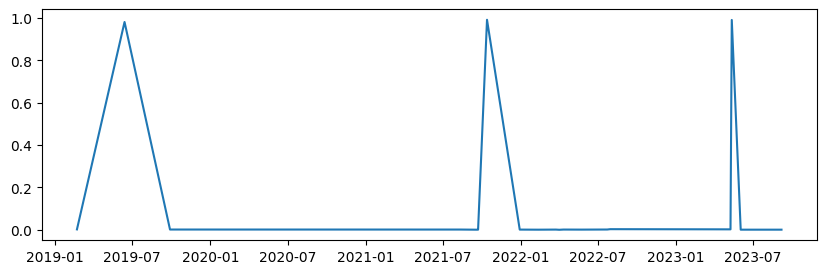

In [16]:
df[0].plot(figsize=(10,3))

# lda prior

In [14]:
lst_topic_seeds = [[*chain(*list(v.values()))] for k, v in DICT_NARRATIVES.items()]
lst_topic_seeds_num = [[dict_txt2vec[w] for w in topic if w in dict_txt2vec.keys()] for topic in lst_topic_seeds]

In [15]:
plda = PTWGuidedLatentDirichletAllocation(
    n_components=len(lst_topic_seeds),
    learning_decay=.8,
    learning_offset=100,
    learning_method='online',
    batch_size=900,
    random_state=101,
    ptws=lst_topic_seeds_num,
    n_jobs=-1,
)
plda_out = plda.fit(vec.toarray())

In [16]:
get_lda_n_top_words(voc, plda_out)


Topic 0
inflation inflationsrate kaufpreis wirtschaft geld usa ökonom unternehmen bank wert

Topic 1
lohn arbeitnehmer beschäftigter mitarbeiter gehalt arbeitslosigkeit arbeitslosenquote arbeitslosenzahl unternehmen wirtschaft

Topic 2
kosten produktion lieferkette handel hersteller import halbleiter unternehmen problem wirtschaft

Topic 3
ukraine krieg russland konflikt sanktion unternehmen geld wirtschaft usa grund

Topic 4
preis energie gas öl strom erdgas nord unternehmen stream geld

Topic 5
nachfrage verbraucher kunde haushalt ausgabe konsum unternehmen geld grund problem

Topic 6
pandemie corona virus covid problem staat wirtschaft geld usa mensch

Topic 7
zins unternehmen wirtschaft geld usa ezb zentralbank notenbank wert bank

Topic 8
krise rezession fall ökonom risiko unternehmen problem geld wirtschaft mensch


In [17]:
# cross validation random search

In [27]:
cv_plda = RandomizedSearchCV(plda,
                             dict(
                                 learning_decay=uniform(.7,.1),
                                 learning_offset=uniform(10, 90),
                                 ptws_bias=uniform(4,6),
                                 # batch_size=2_000,
                             ),
                             n_iter=20,
                             n_jobs=-1,
                             random_state=101,                             
                            )

In [28]:
from joblib import parallel_backend

with parallel_backend('threading', n_jobs=3):
    cv_plda_out = cv_plda.fit(vec.toarray())
    out_plda_cv = cv_plda_out.best_estimator_

In [29]:
# cv_plda_out = cv_plda.fit(X)
# out_plda_cv = cv_plda_out.best_estimator_

In [31]:
get_lda_n_top_words(voc, out_plda_cv)


Topic 0
inflation inflationsrate kaufpreis wirtschaft geld ökonom unternehmen usa bank wert

Topic 1
lohn arbeitnehmer beschäftigter mitarbeiter gehalt arbeitslosigkeit arbeitslosenquote gehälter beschäftigungsverhältnis altersgruppe

Topic 2
kosten produktion lieferkette handel hersteller import halbleiter unternehmen kosteninflation problem

Topic 3
ukraine krieg russland konflikt sanktion etatplan unternehmen frühjahrsprojektion bewirtschaftungskoste eckdatum

Topic 4
preis energie gas unternehmen geld mensch problem öl bundesregierung staat

Topic 5
nachfrage verbraucher kunde haushalt ausgabe konsum umsatz markt händler konzern

Topic 6
pandemie corona virus covid problem wirtschaft geld unternehmen usa staat

Topic 7
zins wirtschaft ezb zentralbank unternehmen usa notenbank bank ökonom geld

Topic 8
krise rezession unternehmen wirtschaft problem ökonom geld fall folge risiko


In [32]:
# plot

In [33]:
df = pd.DataFrame(plda_out.transform(X), columns=DICT_NARRATIVES.keys(), index=lst_dates)
df.sort_index(inplace=True)

In [34]:
df_g = (df.reset_index().groupby('index').sum() / df.reset_index().groupby('index').inflation.count().values[:,None]).copy()
df_g = df_g.rolling(15).mean()

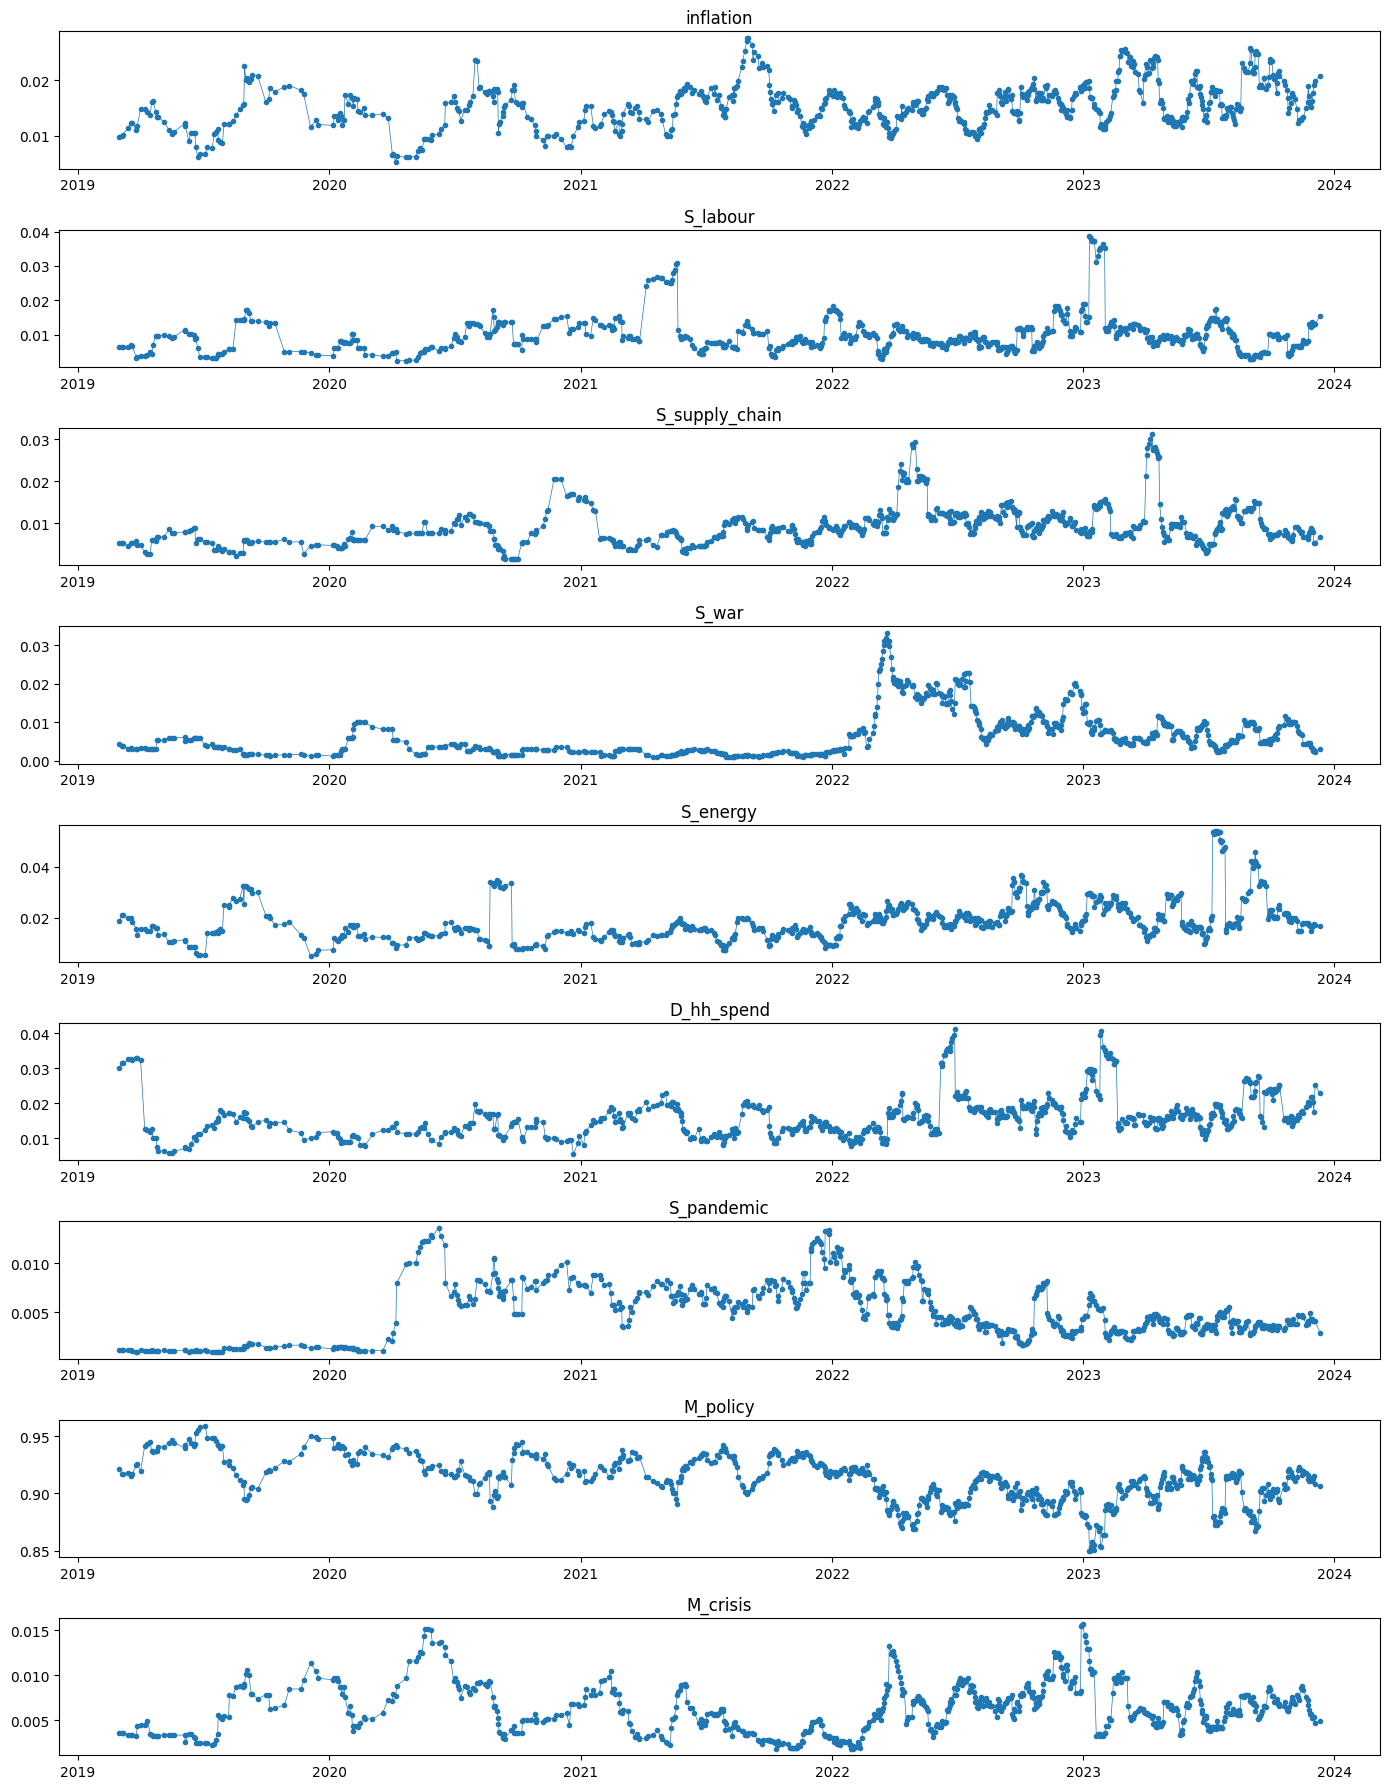

In [35]:
fig, axes = plt.subplots(df.shape[1], 1, figsize=(14, 2*df.shape[1]))
for idx, ax in enumerate(axes.ravel()):
    ax.plot(df_g.iloc[:, idx], lw=.5, marker='.')
    ax.set_title(df_g.columns[idx])
plt.tight_layout()

In [14]:
df.index.name = 'date'
df['id'] = lst_ids

In [16]:
save_pd_df(df, "lda_topics.feather")

In [ ]:
save_pkl(out_plda_cv, 'plda_cv_v01.pkl', f_path=MODELS_DIR)